<a href="https://colab.research.google.com/github/alanexplorer/Robotic-Algorithm-Tutorial/blob/master/particle_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import numpy as np
from math import pi, sqrt, cos, sin, tan, exp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, Ellipse

In [0]:
#CONST

landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

In [0]:
class robot:
  def __init__(self):
    self.x = random.random() * world_size  # initialise with random
    self.y = random.random() * world_size
    self.theta = random.random() * 2.0 * pi

    self.forward_noise = 0.0
    self.turn_noise    = 0.0
    self.sense_noise   = 0.0

  def get(self):
    return (self.x, self.y, self.theta)
    
  def set(self, new_x, new_y, new_theta):
    if new_x < 0 or new_x >= world_size:
        raise ValueError('X coordinate out of bound')
    if new_y < 0 or new_y >= world_size:
        raise ValueError('Y coordinate out of bound')
    if new_theta < 0 or new_theta >= 2 * pi:
        raise ValueError('theta must be in [0..2pi]')
    self.x = float(new_x)
    self.y = float(new_y)
    self.theta = float(new_theta)
    
    
  def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
    # makes it possible to change the noise parameters
    # this is often useful in particle filters
    self.forward_noise = float(new_f_noise)
    self.turn_noise    = float(new_t_noise)
    self.sense_noise   = float(new_s_noise)

  def sense(self):
      Z = []
      for i in range(len(landmarks)):
          dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
          dist += random.gauss(0.0, self.sense_noise)
          Z.append(dist)
      return Z


  def move(self, turn, forward):
      if forward < 0:
          raise ValueError('Robot cant move backwards')
      
      # turn, and add randomness to the turning command
      theta = self.theta + float(turn) + random.gauss(0.0, self.turn_noise)
      theta %= 2 * pi
      
      # move, and add randomness to the motion command
      dist = float(forward) + random.gauss(0.0, self.forward_noise)
      x = self.x + (cos(theta) * dist)
      y = self.y + (sin(theta) * dist)
      x %= world_size    # cyclic truncate
      y %= world_size
      
      # set particle
      res = robot()
      res.set(x, y, theta)
      res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
      return res

  def Gaussian(self, mu, sigma, x):
          # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
          return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
      
      
  def measurement_prob(self, measurement):
      # calculates how likely a measurement should be
      prob = 1.0
      for i in range(len(landmarks)):
          dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
          prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
      return prob

In [346]:
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
print(myrobot.get())

(79.34230642436533, 70.98340513322822, 4.398560281623536)


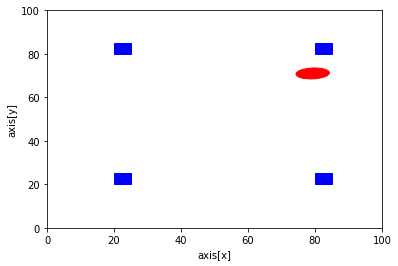

In [347]:
plt.figure()
currentAxis = plt.gca()

for i in range(len(landmarks)):
  currentAxis.add_patch(Rectangle(landmarks[i], 5.0, 5.0, alpha=1, color="blue"))

currentAxis.add_patch(Ellipse((myrobot.get()[0], myrobot.get()[1]), 10.0, 5.0, myrobot.get()[2], alpha=1, color="red"))


plt.ylabel('axis[y]')
plt.xlabel('axis[x]')

plt.xlim((0, 100))   # set the xlim to left, right
plt.ylim((0, 100))     # set the xlim to left, right


plt.show()

In [0]:

N = 1000
p = []

for _ in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)  # add noise
    p.append(x)

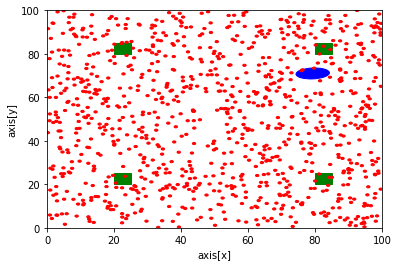

In [349]:
plt.figure()
currentAxis = plt.gca()

for i in range(len(landmarks)):
  currentAxis.add_patch(Rectangle(landmarks[i], 5.0, 5.0, alpha=1, color="green"))

currentAxis.add_patch(Ellipse((myrobot.get()[0], myrobot.get()[1]), 10.0, 5.0, myrobot.get()[2], alpha=1, color="blue"))

for i in range(N):
  currentAxis.add_patch(Ellipse((p[i].get()[0], p[i].get()[1]), 1.0, 1.0, p[i].get()[2], alpha=1, color="red"))



plt.ylabel('axis[y]')
plt.xlabel('axis[x]')

plt.xlim((0, 100))   # set the xlim to left, right
plt.ylim((0, 100))     # set the xlim to left, right


plt.show()

In [0]:
w = []

for rob in p:
    prob = rob.measurement_prob(Z)  # Z remains the same
    w.append(prob)

In [0]:
p3 = []
index = int(random.random()*N)
beta = 0
mw = max(w)

for i in range(N):
    beta += random.random() * 2 * mw
    while beta > w[index]:
        beta -= w[index]
        index = (index + 1)%N
    p3.append(p[index])
p = p3

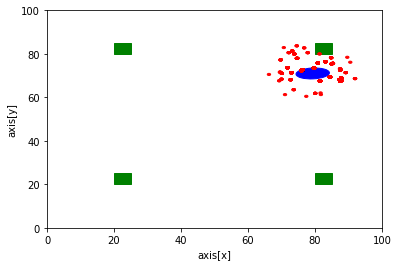

In [352]:
plt.figure()
currentAxis = plt.gca()

for i in range(len(landmarks)):
  currentAxis.add_patch(Rectangle(landmarks[i], 5.0, 5.0, alpha=1, color="green"))

currentAxis.add_patch(Ellipse((myrobot.get()[0], myrobot.get()[1]), 10.0, 5.0, myrobot.get()[2], alpha=1, color="blue"))

for i in range(N):
  currentAxis.add_patch(Ellipse((p[i].get()[0], p[i].get()[1]), 1.0, 1.0, p[i].get()[2], alpha=1, color="red"))



plt.ylabel('axis[y]')
plt.xlabel('axis[x]')

plt.xlim((0, 100))   # set the xlim to left, right
plt.ylim((0, 100))     # set the xlim to left, right


plt.show()